In [1]:
import torch
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
CONTEXT_LENGTH = 3
SPECIAL = '.'

## Class and functions definitions

In [3]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, X, Y):
        super().__init__()
        assert(X.shape[0] == Y.shape[0])
        self.X, self.Y = X, Y

    def __getitem__(self, idx):
        return self.X[idx, ...], self.Y[idx, ...]

    def __len__(self):
        return self.X.shape[0]

In [4]:
def build_dataset_from_names(names: list, context_length: int, special_char: str):
    """
    Build dataset 
    """
    X = list()
    Y = list()
    prepend = "".join([special_char for i in range(context_length)])
    for n in names:
        n_ext = "".join([prepend, n, special_char])
        for i in range(len(n_ext) - context_length):
            x = n_ext[i:i + context_length]
            Y.append(chars_to_int[n_ext[i + context_length]])
            X.append([chars_to_int[c] for c in x])
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [31]:
class MLP(torch.nn.Module):

    def __init__(self, num_embeddings: int ,embedding_dim: int, hidden_dim: int, 
                 context_length: int, char_to_int: dict, original_architecture: bool = False):
        """
        Neural Probabilistic model as defined in the paper from Bengio. It is slightly different
        from what is described in the paper, since there are no skip connections between embedding
        and ouput layer.

        Parameters
        num_embeddings: number of embeddings
        embedding_dim: embedding dimension
        hidden_dim: dimension of the hidden layer
        context_length: number of characters to use for prediction
        char_to_int: mapping character -> int
        paper_architecture: if True add the skip connections as in the original paper
        """
        super().__init__()
        self.context_length = context_length
        self.embedding_dim = embedding_dim
        self.char_to_int = char_to_int
        self.int_to_char = {v: k for k, v in self.char_to_int.items()}
        self.original_architecture = original_architecture
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
        #self.batch_norm = torch.nn.BatchNorm1d(num_features=embedding_dim * context_length)
        self.hidden_layer = torch.nn.Linear(in_features=embedding_dim * context_length, 
                                            out_features=hidden_dim)

        self.hidden_activation = torch.nn.Tanh()
        if self.original_architecture:
            output_dim = hidden_dim + embedding_dim * context_length 
        else:
            output_dim = hidden_dim
            
        self.output_layer = torch.nn.Linear(in_features=output_dim, out_features=num_embeddings)
        self.output_activation = torch.nn.Softmax(dim=1)

    def initialize_kaiming(self, generator=None):
        self.hidden_layer.weight = torch.nn.init.kaiming_normal_(
            self.hidden_layer.weight, mode="fan_in", nonlinearity="tanh", generator=generator)
        self.output_layer.weight = torch.nn.init.kaiming_normal_(
            self.output_layer.weight, mode="fan_in", nonlinearity="linear", generator=generator)
        return self

    def get_activations(self, X):
        activations = list()
        with torch.no_grad():
            C = self.embedding(X).view(-1, self.context_length * self.embedding_dim)
            activations.append(C)
            #out = self.batch_norm(C)
            #activations.append(out)
            out = self.hidden_layer(out)
            out = self.hidden_activation(out)
            activations.append(out)
            if self.original_architecture:
                out = torch.cat([C, out], dim=1)
            out = self.output_layer(out)
            activations.append(out)
        return activations
    
    def forward(self, X):
        """
        Forward pass outputs unnormalized logits
        """
        C = self.embedding(X).view(-1, self.context_length * self.embedding_dim)
        #out = self.batch_norm(C)
        out = self.hidden_layer(C)
        out = self.hidden_activation(out)
        if self.original_architecture:
            out = torch.cat([C, out], dim=1)
        out = self.output_layer(out)
        return out

    def predict_proba(self, X):
        """
        Predict next char proabilities
        """
        logits = self(X)
        return self.output_activation(logits)

    def generate_name(self, generator=None):
        with torch.no_grad():
            res = ""
            start = torch.tensor([[self.char_to_int[c] for c in SPECIAL * self.context_length]])
            next_char = ""
            while next_char != chars_to_int[SPECIAL]:
                probs = model.predict_proba(start)
                next_char = torch.multinomial(probs, num_samples=1, generator=generator)
                res += self.int_to_char[next_char.item()]
                new_start = torch.tensor([[c for c in start[0, 1:]] + [next_char]])
                start = new_start
        return res
        

In [6]:
def regularization(model):
    """
    Regularization loss as described in the paper
    """
    C = list(model.embedding.parameters())[0]
    W = list(model.hidden_layer.parameters())[0]
    O = list(model.hidden_layer.parameters())[0]
    return (C**2).sum() + (W**2).sum() + (O**2).sum()

## Create data

In [7]:
names = np.array(open("data/names_usa.txt").read().splitlines())

In [8]:
generator = torch.Generator().manual_seed(1024)

In [9]:
chars = string.ascii_lowercase + SPECIAL
chars_to_int = {c: k for k,c in enumerate(chars)}
int_to_chars = {k: c for c, k in chars_to_int.items()}

In [10]:
n_names = len(names)
idx = torch.randperm(n_names, generator=generator)
tr_idx = idx[:int(n_names*0.8)]
dev_idx = idx[int(n_names*0.8):int(n_names*0.9)]
te_idx = idx[int(n_names*0.9):]

Xtr, Ytr = build_dataset_from_names(names[tr_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

Xdev, Ydev = build_dataset_from_names(names[dev_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

Xte, Yte = build_dataset_from_names(names[te_idx], 
                               context_length=CONTEXT_LENGTH, 
                               special_char=SPECIAL)

## Model

### Parameters

In [42]:
model_parameters = {
    "num_embeddings": len(chars),
    "embedding_dim": 15,
    "hidden_dim": 60,
    "context_length": CONTEXT_LENGTH,
    "char_to_int": chars_to_int,
    "original_architecture": False
}

epochs = 40
batch_size = 32
loss = torch.nn.CrossEntropyLoss()

## Initialization

Expected loss 3.295836866004329, initial loss 3.3675432205200195


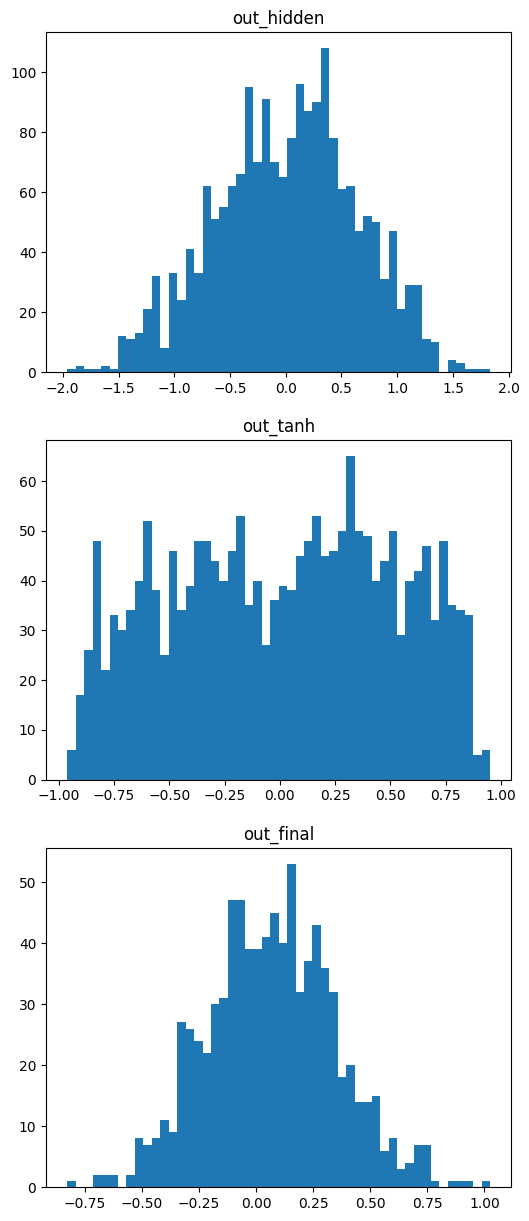

In [43]:
model = MLP(**model_parameters)

uniform_loss = -np.log(1/len(chars))

with torch.no_grad():
    idx = torch.randint(high=Xtr.shape[0], size=(1000,), generator=generator)
    yhat = model(Xtr[idx])
    l = torch.functional.F.cross_entropy(yhat, Ytr[idx])
    
print(f"Expected loss {uniform_loss}, initial loss {l}")

fig, axes = plt.subplots(3, 1, figsize=(6, 15))
with torch.no_grad():
    idx = torch.randint(high=Xtr.shape[0], size=(32,), generator=generator)
    out = model.embedding(Xtr[idx])
    out = model.hidden_layer(out.flatten(1))

    axes[0].hist(out.flatten(0).detach(), bins=50);
    axes[0].set_title("out_hidden")
    
    out = model.hidden_activation(out)

    axes[1].hist(out.flatten(0).detach(), bins=50);
    axes[1].set_title("out_tanh")

    out = model.output_layer(out)

    axes[2].hist(out.flatten(0).detach(), bins=50);
    axes[2].set_title("out_final")

### Learning rate search

In [44]:
lre = torch.linspace(-3, 0, 1000)
lri = 10 ** lre

stats = list()

for lr in lri:
    idx = torch.randperm(Xtr.shape[0], generator=generator)[:batch_size]
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    yhat = model(Xtr[idx, ...])
    l = loss(yhat.float(), Ytr[idx]) #+ regularization(model)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()

    stats.append(l.item())

(-3.0, 0.0)

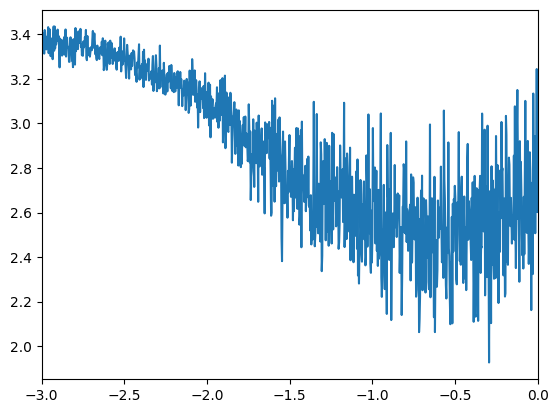

In [45]:
plt.plot(lre, stats)
plt.xlim(-3, 0)
#plt.yscale("log")

### Training

In [50]:
model = MLP(**model_parameters)

data_loader = torch.utils.data.DataLoader(
    Dataset(Xtr, Ytr), 
    batch_size=batch_size, 
    shuffle=True, 
    generator=generator,
    drop_last=True
)

optimizer = torch.optim.SGD(model.parameters(), lr=10**(-1))
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
    optimizer, lr_lambda=lambda x: 0.1 if x % 50 == 0 else 1.)
grad_ratio_history = list()
loss_history = list()

epochs = 60
for e in range(epochs):
    for x, y in data_loader:
        
        optimizer.zero_grad()
        yhat = model(x)
        l = loss(yhat.float(), y)
        l.backward()
        with torch.no_grad():
            lri = optimizer.param_groups[-1]["lr"]
            update = [
                (-model.embedding.weight.grad * lri).std()/model.embedding.weight.std(),
                (-model.hidden_layer.weight.grad * lri).std()/model.hidden_layer.weight.std(),
                (-model.output_layer.weight.grad * lri).std()/model.output_layer.weight.std(),
                lri
            ]
            grad_ratio_history.append(tuple(update))
        optimizer.step()
        loss_history.append(l.detach())
    
    with torch.no_grad():
        yhat = model(Xtr)
        ltr = loss(yhat.float(), Ytr)
        yhat_dev = model(Xdev)
        ldev = loss(yhat_dev.float(), Ydev)
        print(f"Epoch {e}: loss {ltr.item():.4f} {ldev.item():.4f}")
    scheduler.step()

Epoch 0: loss 2.2716 2.2685
Epoch 1: loss 2.2207 2.2246
Epoch 2: loss 2.1973 2.2081
Epoch 3: loss 2.1832 2.1989
Epoch 4: loss 2.1744 2.1911
Epoch 5: loss 2.1714 2.1908
Epoch 6: loss 2.1718 2.1884
Epoch 7: loss 2.1592 2.1773
Epoch 8: loss 2.1596 2.1777
Epoch 9: loss 2.1566 2.1777
Epoch 10: loss 2.1626 2.1878
Epoch 11: loss 2.1509 2.1758
Epoch 12: loss 2.1541 2.1786
Epoch 13: loss 2.1494 2.1766
Epoch 14: loss 2.1567 2.1805
Epoch 15: loss 2.1563 2.1845
Epoch 16: loss 2.1478 2.1739
Epoch 17: loss 2.1444 2.1724
Epoch 18: loss 2.1473 2.1749
Epoch 19: loss 2.1480 2.1780
Epoch 20: loss 2.1463 2.1804
Epoch 21: loss 2.1443 2.1760
Epoch 22: loss 2.1428 2.1717
Epoch 23: loss 2.1408 2.1738
Epoch 24: loss 2.1362 2.1660
Epoch 25: loss 2.1400 2.1732
Epoch 26: loss 2.1381 2.1703
Epoch 27: loss 2.1384 2.1685
Epoch 28: loss 2.1383 2.1677
Epoch 29: loss 2.1370 2.1681
Epoch 30: loss 2.1362 2.1675
Epoch 31: loss 2.1318 2.1654
Epoch 32: loss 2.1393 2.1694
Epoch 33: loss 2.1322 2.1675
Epoch 34: loss 2.1362 2.

In [104]:
model = MLP(**model_parameters)

data_loader = torch.utils.data.DataLoader(
    Dataset(Xtr, Ytr), 
    batch_size=batch_size, 
    shuffle=True, 
    generator=generator,
    drop_last=True
)

optimizer = torch.optim.SGD(model.parameters(), lr=10**(-1))
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
    optimizer, lr_lambda=lambda x: 0.5 if x % 100000 == 0 and x > 0 else 1.)
grad_ratio_history = list()
loss_history = list()

iterations = 200000

for i in range(iterations):
    idx = torch.randint(high=Xtr.shape[0], size=(batch_size,))
    x, y = Xtr[idx, ...], Ytr[idx, ...]
    optimizer.zero_grad()
    yhat = model(x)
    l = loss(yhat.float(), y)
    l.backward()
    with torch.no_grad():
        lri = optimizer.param_groups[-1]["lr"]
        update = [
            (-model.embedding.weight.grad * lri).std()/model.embedding.weight.std(),
            (-model.hidden_layer.weight.grad * lri).std()/model.hidden_layer.weight.std(),
            (-model.output_layer.weight.grad * lri).std()/model.output_layer.weight.std(),
            lri
        ]
        grad_ratio_history.append(tuple(update))
    optimizer.step()
    loss_history.append(l.detach())
    if i % 10000 == 0:
        print(f"Iteration {i} loss: {l.detach()}")

    scheduler.step()

Iteration 0 loss: 3.412269115447998
Iteration 10000 loss: 1.938246250152588
Iteration 20000 loss: 2.328277111053467
Iteration 30000 loss: 1.7016724348068237
Iteration 40000 loss: 2.251211166381836
Iteration 50000 loss: 2.2700657844543457
Iteration 60000 loss: 1.9693427085876465
Iteration 70000 loss: 2.0988829135894775
Iteration 80000 loss: 2.2773098945617676
Iteration 90000 loss: 2.3714253902435303
Iteration 100000 loss: 2.3254787921905518
Iteration 110000 loss: 2.0030477046966553
Iteration 120000 loss: 1.6821868419647217
Iteration 130000 loss: 2.0559866428375244
Iteration 140000 loss: 2.044001817703247
Iteration 150000 loss: 2.1683435440063477
Iteration 160000 loss: 2.152644157409668
Iteration 170000 loss: 2.160306215286255
Iteration 180000 loss: 2.3314146995544434
Iteration 190000 loss: 2.073253631591797


## Training diagnostic

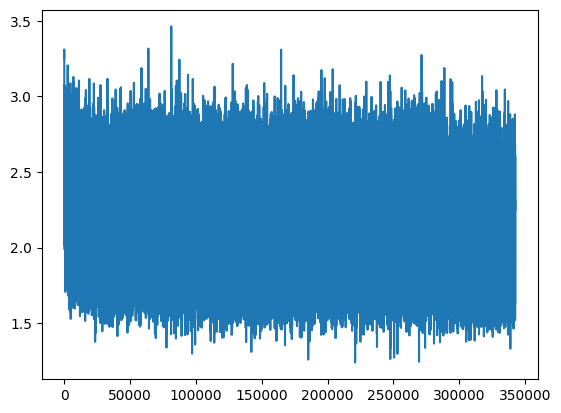

In [51]:
plt.plot(loss_history)

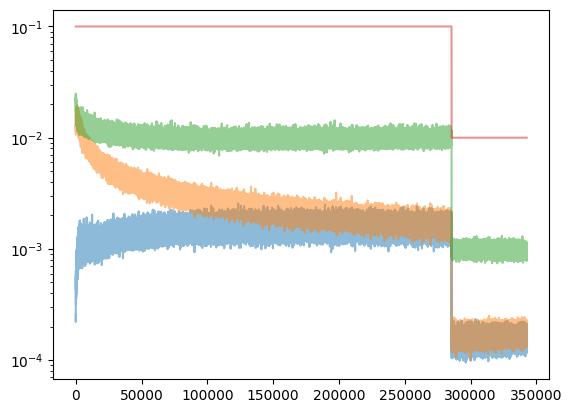

In [52]:
plt.plot(torch.Tensor(grad_ratio_history), alpha=0.5)
plt.yscale("log")

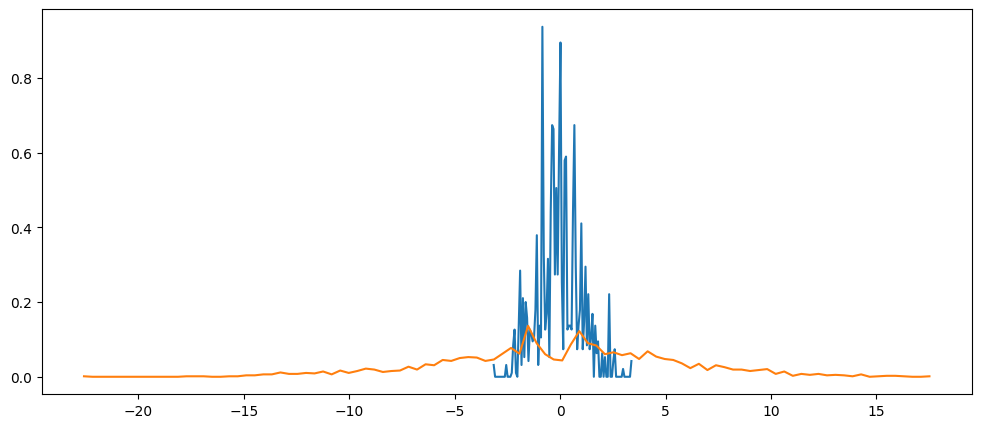

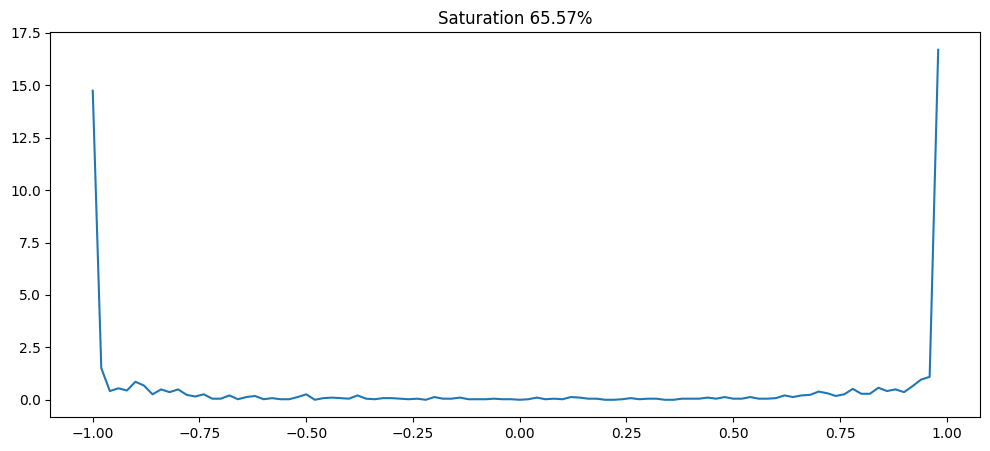

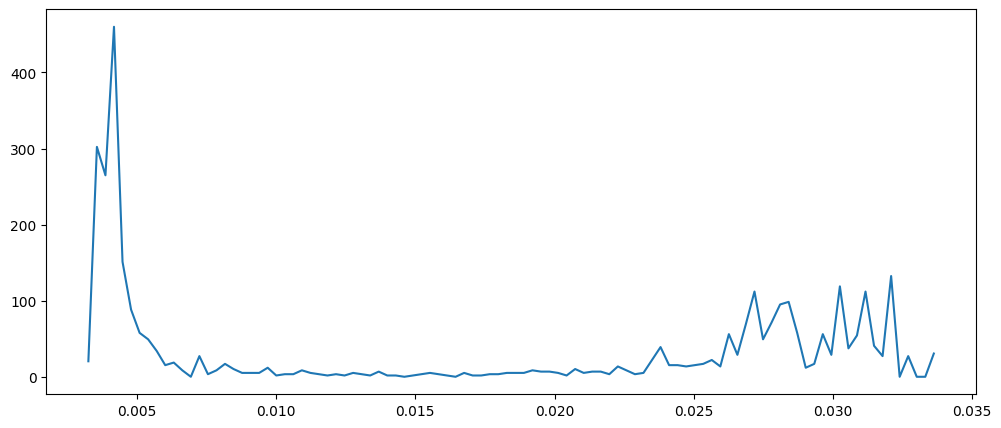

In [53]:
with torch.no_grad():
    idx = torch.randint(high=Xtr.shape[0], size=(batch_size,))
    x = Xtr[idx]
    out = model.embedding(x)
    hist, edges = torch.histogram(out.flatten(), density=True)
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(edges[:-1], hist)

    out = model.hidden_layer(out.flatten(1))
    hist, edges = torch.histogram(out.flatten(), density=True)
    ax.plot(edges[:-1], hist)
    out = model.hidden_activation(out)
    hist, edges = torch.histogram(out.flatten(), density=True)

    
    fig, ax2 = plt.subplots(figsize=(12, 5))
    ax2.plot(edges[:-1], hist)
    ax2.set_title(f"Saturation {(out.abs() > 0.97).float().mean() * 100:.2f}%")

    out = model.output_activation(out)
    hist, edges = torch.histogram(out.flatten(), density=True)
    fig, ax3 = plt.subplots(figsize=(12, 5))
    ax3.plot(edges[:-1], hist)

### Evaluation

In [54]:
with torch.no_grad():
    yhat = model(Xtr)
    ltr = loss(yhat.float(), Ytr)
    yhat_dev = model(Xdev)
    ldev = loss(yhat_dev.float(), Ydev)
    yhat_te = model(Xte)
    lte = loss(yhat_te.float(), Yte)
    print(f"Loss: train {ltr.item():.4f} dev {ldev.item():.4f} test {lte:.4f}")

Loss: train 2.0939 dev 2.1330 test 2.1361


## Generate new names

In [55]:
for _ in range(10):
    print(model.generate_name(generator=generator))

jorgey.
lal.
barreeuna.
muriah.
mada.
tilil.
aileio.
avrustino.
den.
josian.
